In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

#DL import

from tensorflow.keras.layers import Dense, Reshape, Flatten,  Conv1D
from tensorflow.keras.models import Sequential

#ML import
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier


In [75]:
df = pd.read_csv('star_classification.csv')
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Text(0.5, 1.0, 'Number of instances for each class of stellar objects')

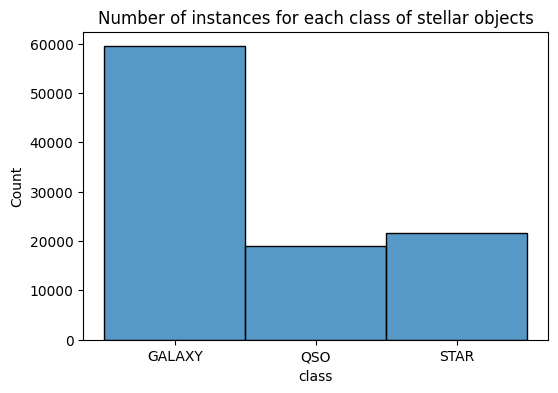

In [76]:
plt.figure(figsize = (6,4))
sns.histplot(data = df, x = 'class')
plt.title('Number of instances for each class of stellar objects')

<Axes: xlabel='alpha', ylabel='Density'>

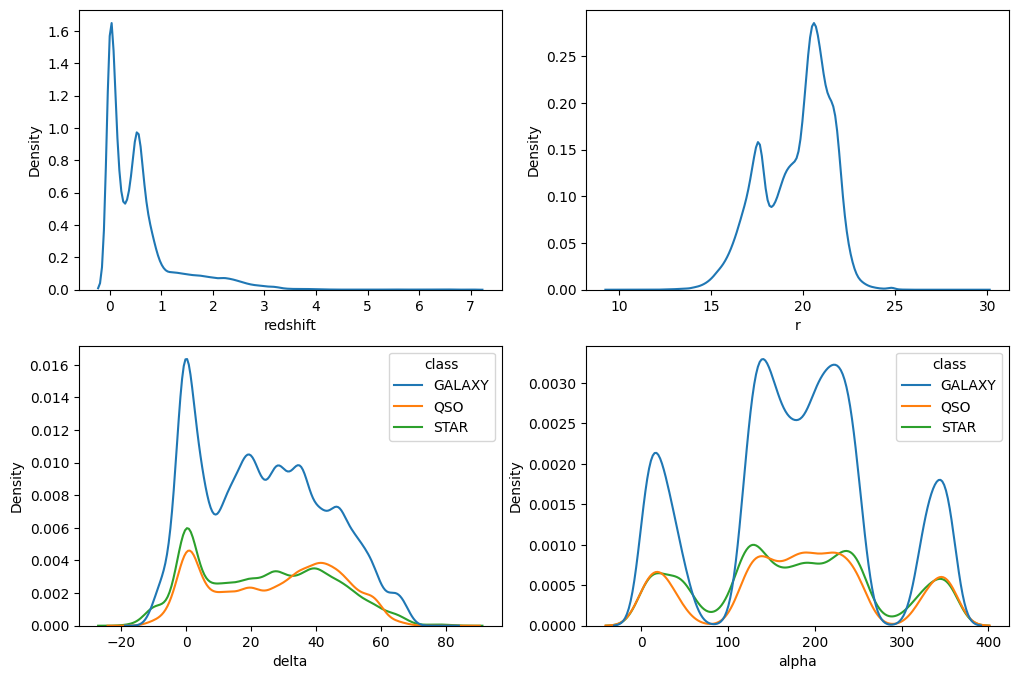

In [77]:
fig, ax = plt.subplots(2,2, figsize = (12,8))
sns.kdeplot(data = df, x = 'redshift', ax = ax[0,0])
sns.kdeplot(data = df, x = 'r', ax = ax[0,1])
sns.kdeplot(data = df, x = 'delta', hue = 'class', ax = ax[1,0])
sns.kdeplot(data = df, x = 'alpha', hue = 'class', ax = ax[1,1])

In [78]:
#Encode the 'class' target in numeric format
LE = LabelEncoder()
df['class'] = LE.fit_transform(df['class'])

<Axes: >

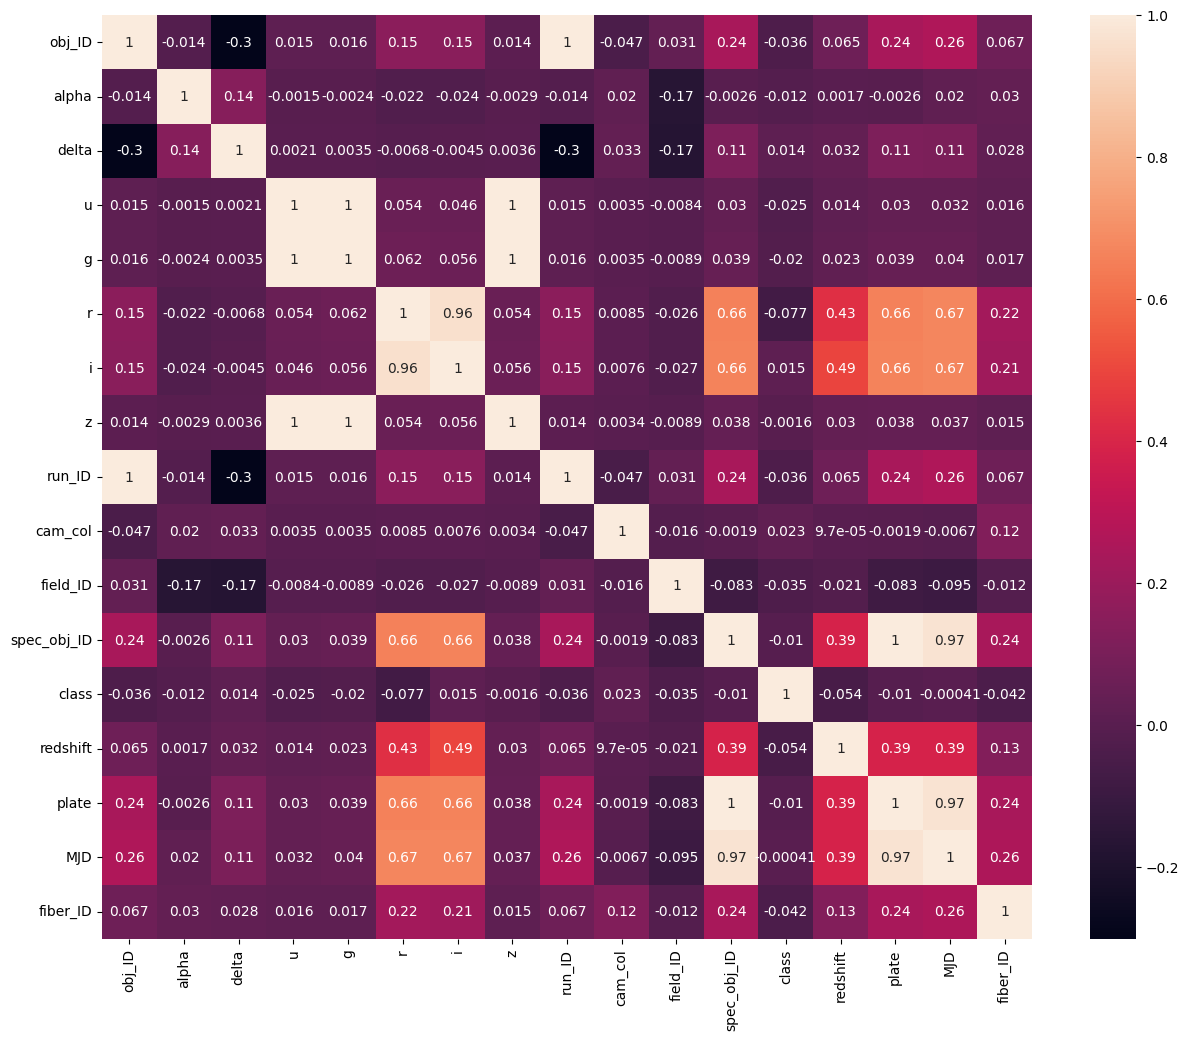

In [79]:
plt.figure(figsize = (15,12))
sns.heatmap(df.drop(['rerun_ID'],axis = 1).corr(),annot = True)

In [80]:
Xr = df[['u', 'g', 'i', 'z', 'r', 'redshift']]
yr = df['class']

Xr = np.array(Xr)
yr = np.array(yr)

xr_train, xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size = 0.2, random_state = 210)
xr_train.shape, xr_test.shape, yr_train.shape, yr_test.shape

((80000, 6), (20000, 6), (80000,), (20000,))

In [81]:
classifiers = [
    SVC(),
    MLPClassifier()
]

In [82]:
best_accuracy = 0.0
acc_list = []
classifier_list = []

for classifier in classifiers:
    pipeline = make_pipeline(StandardScaler(), classifier)
    pipeline.fit(xr_train, yr_train)
    
    yr_pred = pipeline.predict(xr_test)
    
    accuracy = accuracy_score(yr_test, yr_pred)
    acc_list.append(accuracy)
    classifier_list.append(classifier.__class__.__name__)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = classifier.__class__.__name__
    
d = {'Model': classifier_list, 'Accuracy': acc_list}
cl_df = pd.DataFrame(d, index = None)
cl_df = cl_df.set_index('Model')   

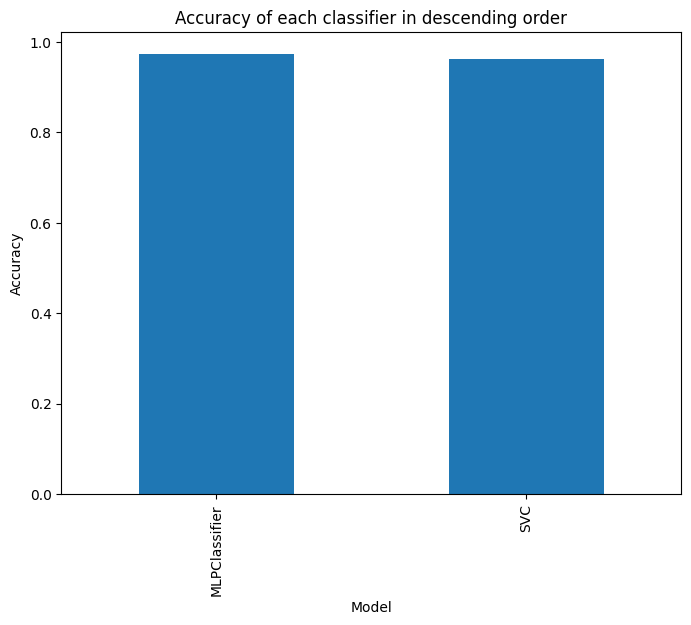

In [83]:
plt.figure(figsize = (8,6));
cl_df['Accuracy'].sort_values(ascending = False).plot(kind = 'bar')
plt.ylabel('Accuracy');
plt.title('Accuracy of each classifier in descending order');

In [84]:
cl_df

,Accuracy
Model,
SVC,0.96270
MLPClassifier,0.97345


## MLPClassifier: Tuning for best model

In [85]:
# Create the pipeline with named steps
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', MLPClassifier())
])

# Define the parameter grid
param_grid = [ 
    {'estimator__solver': ['adam'],
     'estimator__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
     'estimator__max_iter': [10],
     'estimator__hidden_layer_sizes': [(20,), (20, 10), (50, 30)],
     'estimator__activation': [ 'relu'],
     'estimator__alpha': [0.0001, 0.001, 0.01, 0.1],
     'estimator__early_stopping': [True, False]
     }]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(xr_train, yr_train)

# Print the best parameters
best_params = grid_search.best_params_
print(best_params)

{'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__early_stopping': True, 'estimator__hidden_layer_sizes': (50, 30), 'estimator__learning_rate_init': 0.01, 'estimator__max_iter': 10, 'estimator__solver': 'adam'}


In [86]:
# Create the best model using the best parameters
best_model = MLPClassifier(
    solver=best_params['estimator__solver'],
    learning_rate_init=best_params['estimator__learning_rate_init'],
    max_iter=best_params['estimator__max_iter'],
    hidden_layer_sizes=best_params['estimator__hidden_layer_sizes'],
    activation=best_params['estimator__activation'],
    alpha=best_params['estimator__alpha'],
    early_stopping=best_params['estimator__early_stopping']
)

# Fit the best model to the training data
best_model.fit(xr_train, yr_train)

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(50, 30),
              learning_rate_init=0.01, max_iter=10)

In [87]:
preds = best_model.predict(xr_test)

<Figure size 600x600 with 0 Axes>

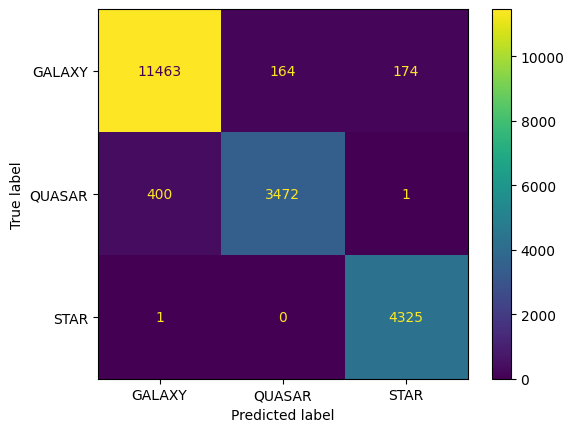

In [88]:
plt.figure(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(yr_test, preds, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

In [89]:
mlp_acc = accuracy_score(yr_test, preds)
mlp_acc

0.963

## SVClassifier: Tuning for best model

In [90]:
x = [0.1]
y = [0.1]
z = [2,3,4]   
parameters =[ 
   #{'C': x,'kernel': ['linear']},
            {'C': x,'kernel': ['rbf'],'gamma': y} ,
            #{'C': x,'kernel': ['poly'],'gamma': y,'degree': z}
]


grid_search_2 = GridSearchCV(
    SVC(),
    param_grid=parameters,
    
     n_jobs=-1,
    verbose=True
)

grid_search_2.fit(xr_train, yr_train)

best_params_2 = grid_search_2.best_params_
print(best_params_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [91]:

# Best model after tuning

model_2 = SVC( C=best_params_2['C'], kernel=best_params_2['kernel'], gamma=best_params_2['gamma'])
model_2.fit(xr_train, yr_train)

SVC(C=0.1, gamma=0.1)

In [92]:
preds_2 = model_2.predict(xr_test)

<Figure size 600x600 with 0 Axes>

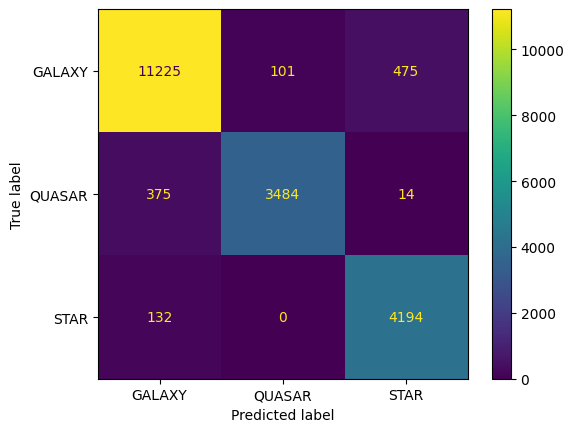

In [93]:
plt.figure(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(yr_test, preds_2, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])



In [94]:
svc_acc = accuracy_score(yr_test, preds_2)
svc_acc

0.94515


### Classification with CNN¶

We need to re-encode the 'class' target in a format usable by the CNN built for classification task.

The encoding is as follows:

'GALAXY' -> [1,0,0] -> 0,  'STAR' -> [0,0,1] -> 2,  'QSO' -> [0,1,0] -> 1



In [95]:
from keras.utils import to_categorical
l_encode = LabelEncoder()
l_encode.fit(yr)
Yr = l_encode.transform(yr)
Yr = to_categorical(Yr)

In [96]:
xr_train, xr_test, yr_train, yr_test = train_test_split(Xr, Yr, test_size = 0.2, random_state = 210)
xr_train.shape, xr_test.shape, yr_train.shape, yr_test.shape

((80000, 6), (20000, 6), (80000, 3), (20000, 3))

In [101]:
# Reshape the data to fit the Conv1D input requirements
xr_train_reshaped = xr_train.reshape((xr_train.shape[0], xr_train.shape[1], 1))
xr_test_reshaped = xr_test.reshape((xr_test.shape[0], xr_test.shape[1], 1))

# Define the model
model_4 = Sequential([
    Conv1D(filters=10, kernel_size=2, activation='relu',
           input_shape=(xr_train.shape[1], 1)),
    Conv1D(filters=10, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(3, activation='softmax')
])

model_4.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

model_4.fit(xr_train_reshaped, yr_train, validation_data=(
    xr_test_reshaped, yr_test), epochs=40, verbose=0)

<Axes: >

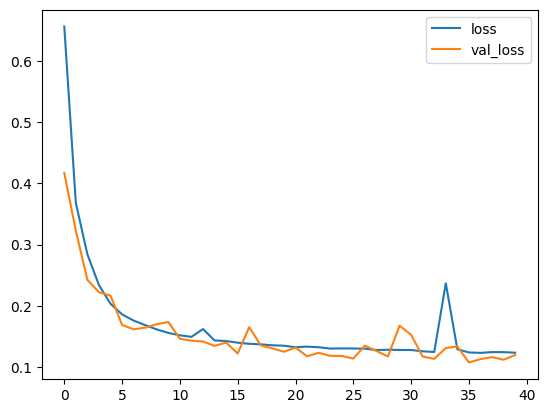

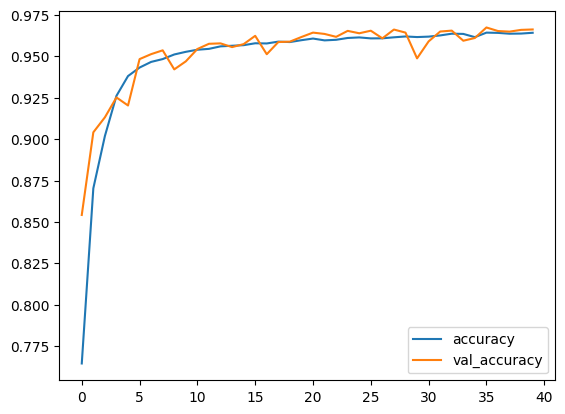

In [102]:
model4_loss_acc = pd.DataFrame(model_4.history.history)
model4_loss_acc[['loss', 'val_loss']].plot()
model4_loss_acc[['accuracy', 'val_accuracy']].plot()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step


<Figure size 600x600 with 0 Axes>

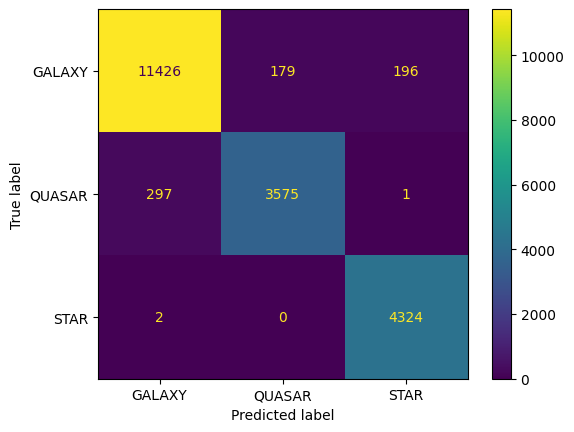

In [103]:
preds_4 = np.round(model_4.predict(xr_test))

plt.figure(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(yr_test.argmax(axis = 1),preds_4.argmax(axis = 1),
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

In [104]:
cnn_acc = accuracy_score(yr_test.argmax(axis = 1), preds_4.argmax(axis =1))
cnn_acc

0.96625

## Shallow vs DL

In [105]:
dc = {'Methods': ['MLPClassifier', 'SVC', 'CNN'], 'Accuracy': [mlp_acc, svc_acc, cnn_acc]}
dcf = pd.DataFrame(data=dc)
dcf = dcf.set_index('Methods') 

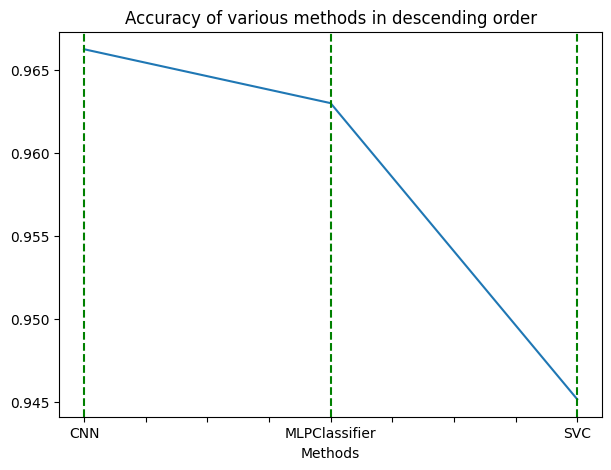

In [106]:
f, ax = plt.subplots(figsize = (7,5))
dcf['Accuracy'].sort_values(ascending = False).plot(ax = ax)
ax.axvline("CNN", color="green", linestyle="dashed")

ax.axvline("MLPClassifier", color="green", linestyle="dashed")
ax.axvline("SVC", color="green", linestyle="dashed")
plt.title('Accuracy of various methods in descending order');